### 前處理：類別分類

In [ ]:
import pandas as pd
import glob
import os

# 設定讀取CSV檔的路徑（你可以根據實際情況修改）
csv_files = glob.glob("/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604*/P*.csv")  
#/Users/nantienchen/Coding/未處理資料/A16/P*/P*.csv


# 設定三個結果資料夾（正常、異常、故障）
output_base = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/P1604"
folder_normal = os.path.join(output_base, "正常")
folder_abnormal = os.path.join(output_base, "異常")
folder_faulty = os.path.join(output_base, "故障")
for folder in [folder_normal, folder_abnormal, folder_faulty]:
    os.makedirs(folder, exist_ok=True)


# 碳刷異常判斷
def count_zero_to_rise(current_series):
    
    zero_crossings = 0
    current_series = current_series.fillna(0)  # 將 NaN 填充為 0
    previous_value = current_series.iloc[0]
    
    for value in current_series:
        if previous_value <= 0.5 and value > 0.5:
            zero_crossings += 1
        previous_value = value
    
    return zero_crossings
"""
    計算電流低於0.5後再回升的次數。
    :param current_series: 電流數據的 Series。
    :return: 發生的次數。
    """
# 電流合併函數
def merge_current(df):
    df = df.assign(Current=df.apply(lambda row: row['NCurrent'] if row['NLR'] == 1 else row['RCurrent'], axis=1))
    return df


# 定義A區標籤函數
def label_azone(Azone_input):
    Azone = Azone_input.copy() 
    # 合併電流欄位
    Azone = merge_current(Azone)

    max_current = Azone['Current'].max()
    
    zero_to_rise = count_zero_to_rise(Azone['Current'])
    
    if zero_to_rise > 2:
        Azone['Label'] = '2'
    elif 10 <= max_current <= 15:
        Azone['Label'] = '0'
    elif max_current > 15:
        Azone['Label'] = '1'
    else:
        Azone['Label'] = '2'
    
    # 新增 worktime 欄位
    # Azone['worktime'] = len(Azone) / 100
    Azone['Zone'] = 'A'  # 標註區間為 A
    return Azone

# 定義B區標籤函數
def label_bzone(Bzone_input):
    Bzone = Bzone_input.copy()
    Bzone = merge_current(Bzone) # 假設此函數已定義

    # 1. 數據分段
    # 判斷是 N 向或 R 向來決定用哪個旗標
    direction_flag = 'SRWKR' if Bzone['NLR'].iloc[0] == 1 else 'SNWKR'
    
    roller_section = Bzone[Bzone[direction_flag] == 1]
    spike_section = Bzone[Bzone[direction_flag] != 1]
    
    roller_label = '0' # 預設為正常
    spike_label = '0' # 預設為正常

    # 2. 上滾輪階段判斷 (基於最大值)
    if not roller_section.empty:
        max_current_roller = roller_section['Current'].max()
        if max_current_roller > 4:
            roller_label = '2'  # 故障
        elif max_current_roller > 3.5: # 注意：圖例的異常是 >3.5A
            roller_label = '1'  # 異常
        # elif max_current_roller < 2: # 正常條件
        #     roller_label = '0'

    # 3. 尖軌階段判斷 (基於平均值，更能反映穩態)
    if not spike_section.empty:
        mean_current_spike = spike_section['Current'].mean()
        if 4 <= mean_current_spike <= 4.5:
            spike_label = '2'  # 故障
        elif 3.5 <= mean_current_spike < 4:
            spike_label = '1'  # 異常
        elif 2.5 <= mean_current_spike < 3:
            spike_label = '0'  # 正常

    # 4. 統一標籤：取最嚴重的標籤作為整個B區的標籤
    # 標籤嚴重等級: '2' > '1' > '0'
    final_label = max(roller_label, spike_label)
    Bzone['Label'] = final_label
    
    # 額外故障檢查：電流掉落
    zero_to_rise = count_zero_to_rise(Bzone['Current'])
    if zero_to_rise > 2:
        Bzone['Label'] = '2'

    # 新增 worktime 和 Zone 欄位
    # Bzone['worktime'] = len(Bzone) / 100
    Bzone['Zone'] = 'B'
    
    # print(f"B區滾輪階段最大電流: {max_current_roller:.2f}A, 標籤: {roller_label}")
    # print(f"B區尖軌階段平均電流: {mean_current_spike:.2f}A, 標籤: {spike_label}")
    # print(f"B區最終統一標籤為: {Bzone['Label'].iloc[0]}")

    return Bzone

# 定義C區標籤函數
def label_czone(Czone_input):
    Czone = Czone_input.copy()
    Czone = merge_current(Czone)

    # 優先判斷碳刷異常
    zero_to_rise = count_zero_to_rise(Czone['Current'])
    if zero_to_rise > 2:
        Czone['Label'] = '2'
        # (省略 worktime/Zone 賦值，在函數末尾統一處理)
        # print("C區因電流多次歸零判斷為 [2: 故障]")
        # ... (添加 worktime/Zone 後 return)
        Czone['Zone'] = 'C'
        return Czone

    # 提取有效電流的起始值和結束值
    valid_current = Czone['Current'][Czone['Current'] > 0.5].reset_index(drop=True) # 閾值設為0.5避免噪點

    if valid_current.empty or len(valid_current) < 2:
        Czone['Label'] = '2' # 數據不足，視為故障
    else:
        start_current = valid_current.iloc[0]
        end_current = valid_current.iloc[-1]
        
        # print(f"C區起始電流: {start_current:.2f}A, 結束電流: {end_current:.2f}A")

        # 1. 故障判斷 (最高優先級)
        if end_current > start_current:
            Czone['Label'] = '2'
        
        # 2. 正常判斷
        # 起始電流較低 (< 3A)，且有明顯的下降 (>= 0.5A)
        elif start_current < 3 and (start_current - end_current) >= 0.5:
            Czone['Label'] = '0'
        
        # 3. 異常判斷 (所有其他情況)
        # 包括：起始電流過高(>=3A)，或起始與結束值接近
        else:
            Czone['Label'] = '1'

    # Czone['worktime'] = len(Czone) / 100
    Czone['Zone'] = 'C'
    
    # print(f"C區最終判斷為: [{Czone['Label'].iloc[0]}]")
    
    return Czone

# ========== 開始主迴圈 ==========
for file in csv_files:
    df = pd.read_csv(file)

    # --- 區間分割 ---
    Azone = df[((df['NLR'] == 1) & (df['RWKR'] == 1)) | ((df['NLR'] == 0) & (df['NWKR'] == 1))]
    Bzone = df[((df['NLR'] == 1) & (df['RWKR'] != 1) & (df['SNWKR'] != 1)) | ((df['NLR'] == 0) & (df['NWKR'] != 1) & (df['SRWKR'] != 1))]
    Czone = df[((df['NLR'] == 1) & (df['SNWKR'] == 1)) | ((df['NLR'] == 0) & (df['SRWKR'] == 1))]

    # --- 各區標註 ---
    Azone_labeled = label_azone(Azone) if not Azone.empty else pd.DataFrame()
    Bzone_labeled = label_bzone(Bzone) if not Bzone.empty else pd.DataFrame()
    Czone_labeled = label_czone(Czone) if not Czone.empty else pd.DataFrame()

    # --- 合併所有區域 ---
    all_labeled = pd.concat([Azone_labeled, Bzone_labeled, Czone_labeled], ignore_index=True)

    # 若三區都無資料則跳過
    if all_labeled.empty:
        print(f"{file} 無有效區域資料，已跳過。")
        continue

    # --- 抓三區的主要標籤（取眾數/最常見，也可改抓最後一筆或你要的判斷方式） ---
    zone_labels = []
    for zone_df in [Azone_labeled, Bzone_labeled, Czone_labeled]:
        if not zone_df.empty:
            # 用眾數，沒標籤就設為-1（或可自訂）
            label_mode = zone_df['Label'].mode()[0] if not zone_df['Label'].mode().empty else -1
            zone_labels.append(int(label_mode))
        else:
            zone_labels.append(-1)  # 若該區沒資料給 -1

        # --- 依據你的邏輯判斷歸類 ---
    count0 = zone_labels.count(0)
    count1 = zone_labels.count(1)
    count2 = zone_labels.count(2)

    if count0 == 3:  # 三區都是正常
        target_folder = folder_normal
        class_name = "正常"
    elif count2 > count1:  # 故障區域比異常多
        target_folder = folder_faulty
        class_name = "故障"
    else:  # 有一區是1或2，但2沒比1多
        target_folder = folder_abnormal
        class_name = "異常"

    # --- 存檔 ---
    out_name = os.path.splitext(os.path.basename(file))[0] + f"_{class_name}.csv"
    all_labeled.to_csv(os.path.join(target_folder, out_name), index=False, encoding='utf-8-sig')
    print(f"{file} 已歸類到「{class_name}」並存檔 {out_name}")

print("全部分類與標註處理完成！")

/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230623015234.csv 已歸類到「異常」並存檔 P1604R_20230623015234_異常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230819215408.csv 已歸類到「異常」並存檔 P1604R_20230819215408_異常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230421044259.csv 已歸類到「異常」並存檔 P1604R_20230421044259_異常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230501033425.csv 已歸類到「異常」並存檔 P1604R_20230501033425_異常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230810021800.csv 已歸類到「異常」並存檔 P1604R_20230810021800_異常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230829044236.csv 已歸類到「正常」並存檔 P1604R_20230829044236_正常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230305215653.csv 已歸類到「異常」並存檔 P1604R_20230305215653_異常.csv
/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1604R/P1604R_20230622045345.csv 已歸類到「異常」並存檔 P1604R_202306

### 區域空值檢查

In [34]:
import pandas as pd
import os
import glob
from collections import defaultdict

# --- 1. 設定要檢查的設備基礎路徑 ---
device_folders = ["P1602", "P1603", "P1604"]  # <--- 在這裡修改或新增你要檢查的設備
base_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料"

# --- 2. 預期應該要存在的所有區域 ---
expected_zones = {'A', 'B', 'C'}

# --- 3. 初始化一個字典來存放有問題的檔案報告 ---
# defaultdict 讓我們可以方便地附加項目到列表中，即使鍵是第一次出現
issues_report = defaultdict(list)

# --- 4. 遍歷所有指定的設備資料夾進行檢查 ---
for device in device_folders:
    device_base_path = os.path.join(base_dir, device)
    
    print(f"正在掃描設備 {device} 的檔案...")
    
    search_pattern = os.path.join(device_base_path, "**/*.csv")
    processed_files = glob.glob(search_pattern, recursive=True)

    if not processed_files:
        print(f"  -> 警告：在 {device_base_path} 中找不到任何 CSV 檔案。")
        continue

    for file_path in processed_files:
        try:
            df = pd.read_csv(file_path)
            
            if 'Zone' in df.columns:
                present_zones = set(df['Zone'].dropna().unique())
                missing_zones = expected_zones - present_zones
                
                if missing_zones:
                    # 如果有缺少區域，就記錄下來
                    file_name = os.path.basename(file_path)
                    missing_list = sorted(list(missing_zones))
                    issues_report[device].append({
                        "file_name": file_name,
                        "missing_zones": missing_list
                    })
            else:
                # 如果連 'Zone' 欄位都沒有，也記錄為問題
                file_name = os.path.basename(file_path)
                issues_report[device].append({
                    "file_name": file_name,
                    "missing_zones": "無 'Zone' 欄位"
                })

        except Exception as e:
            # 讀取檔案出錯也記錄下來
            file_name = os.path.basename(file_path)
            issues_report[device].append({
                "file_name": file_name,
                "missing_zones": f"讀取錯誤: {e}"
            })

print("\n...所有檔案掃描完畢，正在生成報告...")

# --- 5. 列印最終的摘要報告 ---
print("\n==================================================")
print("          設備區域空值檢查摘要報告")
print("==================================================")

total_issues = 0

# 遍歷報告字典
for device, issues in issues_report.items():
    
    # 計算此設備的問題檔案總數
    num_issues = len(issues)
    total_issues += num_issues

    if num_issues > 0:
        # 使用 f-string 的對齊功能，讓輸出更美觀
        # ^30 表示置中對齊，寬度為30個字元
        print(f"\n----------- 設備 {device:^10} (共 {num_issues} 個問題檔案) -----------")
        
        for issue in issues:
            # <50 表示向左對齊，寬度50
            # >20 表示向右對齊，寬度20
            file_info = f"-> 檔案: {issue['file_name']:<50}"
            missing_info = f"問題: 缺少 {str(issue['missing_zones'])}"
            print(file_info + missing_info)
    else:
        print(f"\n----------- 設備 {device:^10} -----------")
        print("  [成功] 此設備所有檔案區域完整！")

print("\n--------------------------------------------------")
print(f"報告總結：共發現 {total_issues} 個檔案存在區域缺失問題。")
print("==================================================")

正在掃描設備 P1602 的檔案...
正在掃描設備 P1603 的檔案...
正在掃描設備 P1604 的檔案...

...所有檔案掃描完畢，正在生成報告...

          設備區域空值檢查摘要報告

----------- 設備   P1602    (共 15 個問題檔案) -----------
-> 檔案: P1602N_20230807015618_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230807015519_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230622012528_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230622020746_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230807015147_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230622021623_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230807015450_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230622022455_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230807015207_故障.csv                      問題: 缺少 ['A', 'B']
-> 檔案: P1602N_20230807012432_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602R_20230522033130_故障.csv                      問題: 缺少 ['A']
-> 檔案: P1602N_20230807020514_異常.csv                      問題: 缺少 ['

In [3]:
import pandas as pd
import os
import glob
from collections import defaultdict

# --- 1. 設定要檢查的設備基礎路徑 ---
device_folders = ["P1602", "P1603", "P1604"]  # <--- 在這裡修改或新增你要檢查的設備
base_dir = "/Users/nantienchen/Coding/已處理資料/3"

# --- 2. 初始化報告字典 ---
issues_report = defaultdict(list)

# --- 3. 遍歷所有設備進行檢查 ---
for device in device_folders:
    device_base_path = os.path.join(base_dir, device)
    print(f"正在掃描設備 {device} 的檔案...")
    
    search_pattern = os.path.join(device_base_path, "**/*.csv")
    processed_files = glob.glob(search_pattern, recursive=True)

    if not processed_files:
        print(f"  -> 警告：在 {device_base_path} 中找不到任何 CSV 檔案。")
        continue

    for file_path in processed_files:
        try:
            df = pd.read_csv(file_path)
            
            # 檢查必要的欄位是否存在
            if 'Label' not in df.columns or 'Zone' not in df.columns:
                continue # 如果連基本欄位都沒有，就跳過這個檔案

            # --- 核心邏輯：找出 'Label' 存在但 'Zone' 是空值(NaN)的資料行 ---
            # pd.isna(df['Zone']) 會找出 Zone 是 NaN 的行
            # pd.notna(df['Label']) 會找出 Label 不是 NaN 的行
            # 兩者用 & 連接，就找到了我們的目標
            missing_zone_tags = df[pd.isna(df['Zone']) & pd.notna(df['Label'])]
            
            if not missing_zone_tags.empty:
                # 如果找到了這樣的問題資料
                file_name = os.path.basename(file_path)
                
                # 找出這些問題資料發生在哪幾個原始區域 (A, B, or C)
                # 這一步需要根據原始的分割邏輯來反推
                # 我們直接檢查這些問題行的特徵
                problem_areas = set()
                for index, row in missing_zone_tags.iterrows():
                    # 根據你原始程式碼的分割邏輯來判斷它屬於哪個區
                    if (row['NLR'] == 1 and row['RWKR'] == 1) or \
                        (row['NLR'] == 0 and row['NWKR'] == 1):
                        problem_areas.add('A')
                    elif (row['NLR'] == 1 and row['SNWKR'] == 1) or \
                        (row['NLR'] == 0 and row['SRWKR'] == 1):
                        problem_areas.add('C')
                    else: # 剩下的歸為 B
                        problem_areas.add('B')

                issues_report[device].append({
                    "file_name": file_name,
                    "problem_zones": sorted(list(problem_areas)),
                    "count": len(missing_zone_tags)
                })

        except Exception as e:
            # 這裡可以選擇性地報告讀取錯誤的檔案
            # print(f"讀取檔案 {os.path.basename(file_path)} 時出錯: {e}")
            pass

print("\n...所有檔案掃描完畢，正在生成報告...")

# --- 4. 列印最終的摘要報告 ---
print("\n==========================================================")
print("         Zone 標記遺漏問題 精準檢查報告")
print("==========================================================")

total_issues = 0

for device, issues in issues_report.items():
    num_issues = len(issues)
    total_issues += num_issues

    if num_issues > 0:
        print(f"\n----------- 設備 {device:^10} (共 {num_issues} 個問題檔案) -----------")
        for issue in issues:
            file_info = f"-> 檔案: {issue['file_name']:<50}"
            issue_info = (f"問題: 區域 {str(issue['problem_zones'])} 中有 "
                        f"{issue['count']} 筆資料已標記 Label 但遺漏 Zone")
            print(file_info + issue_info)
    else:
        print(f"\n----------- 設備 {device:^10} -----------")
        print("  [成功] 此設備所有檔案的 Zone 標記皆完整！")

print("\n----------------------------------------------------------")
print(f"報告總結：共發現 {total_issues} 個檔案存在 Zone 標記遺漏問題。")
print("==========================================================")

正在掃描設備 P1602 的檔案...
  -> 警告：在 /Users/nantienchen/Coding/已處理資料/3/P1602 中找不到任何 CSV 檔案。
正在掃描設備 P1603 的檔案...
  -> 警告：在 /Users/nantienchen/Coding/已處理資料/3/P1603 中找不到任何 CSV 檔案。
正在掃描設備 P1604 的檔案...
  -> 警告：在 /Users/nantienchen/Coding/已處理資料/3/P1604 中找不到任何 CSV 檔案。

...所有檔案掃描完畢，正在生成報告...

         Zone 標記遺漏問題 精準檢查報告

----------------------------------------------------------
報告總結：共發現 0 個檔案存在 Zone 標記遺漏問題。


In [ ]:
from pathlib import Path

ROOT = Path("/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料")

CLASS_MAP = {"正常":0, "異常":1, "故障":2}
INV_CLASS_MAP = {v:k for k,v in CLASS_MAP.items()}

### 各設備資料長度分析

In [6]:
import pandas as pd

def event_key_from_path(p: str) -> str:
    base = Path(p).stem
    for k in CLASS_MAP.keys():
        if base.endswith("_"+k):
            return base[:-(len(k)+1)]
    return base

def build_manifest(root: Path) -> pd.DataFrame:
    rows = []
    for device_dir in root.iterdir():
        if not device_dir.is_dir():
            continue
        for cls_name, y in CLASS_MAP.items():
            d = device_dir / cls_name
            if not d.exists():
                continue
            for csv_path in sorted(d.glob("*.csv")):
                rows.append({
                    "path": str(csv_path),
                    "device": device_dir.name,
                    "event_label": y,
                    "event_key": event_key_from_path(str(csv_path))
                })
    return pd.DataFrame(rows)

manifest = build_manifest(ROOT)
print("總事件數:", len(manifest))
# manifest.head()

# 初始化一個巢狀字典來儲存統計結果
# 結構: { "設備名稱": { "類別名稱": {統計資訊} } }
stats = {}

# 遍歷 manifest 中的每一筆事件紀錄
for index, row in manifest.iterrows():
    path_str = row['path']
    device = row['device']
    event_label = row['event_label']
    class_name = INV_CLASS_MAP[event_label]

    try:
        # 讀取 CSV 檔案並獲取筆數 (長度)
        df = pd.read_csv(path_str)
        length = len(df)
        
        # 如果該設備是第一次出現，先為它初始化一個空字典
        if device not in stats:
            stats[device] = {}

        # 如果該設備的該類別是第一次出現，直接記錄當前資訊
        if class_name not in stats[device]:
            stats[device][class_name] = {
                'min_len': length,
                'min_path': path_str,
                'max_len': length,
                'max_path': path_str,
                'count': 1,
                'all_lengths': [length]
            }
        else:
            # 如果已經有紀錄，則進行比較和更新
            # 更新最短紀錄
            if length < stats[device][class_name]['min_len']:
                stats[device][class_name]['min_len'] = length
                stats[device][class_name]['min_path'] = path_str
            
            # 更新最長紀錄
            if length > stats[device][class_name]['max_len']:
                stats[device][class_name]['max_len'] = length
                stats[device][class_name]['max_path'] = path_str
            
            # 更新計數
            stats[device][class_name]['count'] += 1
            stats[device][class_name]['all_lengths'].append(length)

    except Exception as e:
        print(f"讀取檔案 {path_str} 時發生錯誤: {e}")
        
print("========== 各設備事件長度 ==========")
for device in sorted(stats.keys()):
    print(f"\n--- 設備: {device} ---")
    
    # 按照 "正常", "異常", "故障" 的順序印出
    for class_name in CLASS_MAP.keys():
        if class_name in stats[device]:
            info = stats[device][class_name]
            # 使用 os.path.basename 取得檔名，讓路徑更簡潔
            min_filename = os.path.basename(info['min_path'])
            max_filename = os.path.basename(info['max_path'])
            
            print(f"類別: {class_name} (共 {info['count']} 筆事件)")
            print(f"  最短筆數: {info['min_len']:<5} (檔案: {min_filename})")
            print(f"  最長筆數: {info['max_len']:<5} (檔案: {max_filename})")
            print(f"  各筆長度: {sorted(info['all_lengths'])}") 
        else:
            # 如果該設備沒有某個類別的資料，也明確告知
            print(f"  類別: {class_name} (共 0 筆事件)")



總事件數: 4447
========== 各設備事件長度 ==========

--- 設備: P1602 ---
類別: 正常 (共 105 筆事件)
  最短筆數: 255   (檔案: P1602R_20230605030301_正常.csv)
  最長筆數: 318   (檔案: P1602N_20230420041757_正常.csv)
  各筆長度: [255, 259, 259, 261, 265, 268, 270, 270, 273, 273, 273, 274, 275, 276, 276, 278, 278, 280, 280, 280, 281, 283, 283, 284, 284, 284, 285, 285, 286, 286, 287, 287, 287, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 294, 294, 294, 295, 295, 295, 295, 296, 296, 296, 297, 297, 298, 298, 298, 298, 299, 299, 299, 299, 299, 300, 300, 301, 302, 302, 302, 303, 303, 305, 305, 305, 307, 307, 307, 307, 308, 308, 309, 310, 310, 311, 318]
類別: 異常 (共 804 筆事件)
  最短筆數: 7     (檔案: P1602N_20230613033755_異常.csv)
  最長筆數: 874   (檔案: P1602N_20230622022526_異常.csv)
  各筆長度: [7, 50, 153, 258, 259, 264, 264, 265, 267, 268, 269, 269, 269, 269, 269, 270, 270, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 274, 274, 2

### 資料長度極端值清洗

In [7]:
import pandas as pd
from pathlib import Path
import os
import numpy as np # 引入 numpy 來計算平均值和標準差

# --- 步驟 1: 為 manifest 新增一個 'length' 欄位，避免重複讀取檔案 ---
print("正在計算所有事件的長度...")
lengths = []
for path in manifest['path']:
    try:
        lengths.append(len(pd.read_csv(path)))
    except Exception as e:
        print(f"讀取 {path} 失敗: {e}")
        lengths.append(np.nan) # 如果讀取失敗，標記為 NaN

manifest['length'] = lengths
manifest.dropna(subset=['length'], inplace=True) # 移除讀取失敗的紀錄
manifest['length'] = manifest['length'].astype(int)

print(f"原始總事件數: {len(manifest)}")
print("-" * 50)


# --- 步驟 2: 分組計算統計數據並定義邊界 ---
# 使用 groupby().transform() 可以高效地將計算出的統計值廣播回原始的 DataFrame
# 這一步會為每一行都加上其所屬組別的 mean 和 std
manifest['mean'] = manifest.groupby(['device', 'event_label'])['length'].transform('mean')
manifest['std'] = manifest.groupby(['device', 'event_label'])['length'].transform('std')

# 處理標準差為 0 的情況 (當組內所有長度都一樣時)，避免除以零
manifest['std'].fillna(0, inplace=True)

# 根據 3-sigma 法則定義上下邊界
sigma_multiplier = 1
manifest['lower_bound'] = manifest['mean'] - sigma_multiplier * manifest['std']
manifest['upper_bound'] = manifest['mean'] + sigma_multiplier * manifest['std']


# --- 步驟 3: 過濾數據 ---
# 找出所有落在邊界之外的離群值
outliers = manifest[
    (manifest['length'] < manifest['lower_bound']) | 
    (manifest['length'] > manifest['upper_bound'])
]

# 建立清洗後的新 manifest
manifest_cleaned = manifest[
    (manifest['length'] >= manifest['lower_bound']) & 
    (manifest['length'] <= manifest['upper_bound'])
]

# =============================================================================
#  步驟 4: 美化並印出最終的資料清洗報告
# =============================================================================
print("\n========== 資料清洗分析報告 (基於 3-Sigma 法則) ==========")

# 遍歷每個設備和類別來產生詳細報告
for device in sorted(manifest['device'].unique()):
    print(f"\n--- 設備: {device} ---")
    
    for class_name, label in CLASS_MAP.items():
        # 篩選出特定設備和類別的原始數據
        group_original = manifest[(manifest['device'] == device) & (manifest['event_label'] == label)]
        
        if group_original.empty:
            print(f"  ● 類別: {class_name} (共 0 筆事件)")
            continue
            
        # 篩選出被移除的離群值
        group_outliers = outliers[(outliers['device'] == device) & (outliers['event_label'] == label)]
        
        # 取得統計數據 (因為同一組的值都一樣，所以取第一個即可)
        mean_val = group_original['mean'].iloc[0]
        std_val = group_original['std'].iloc[0]
        lower_b = group_original['lower_bound'].iloc[0]
        upper_b = group_original['upper_bound'].iloc[0]

        print(f"  ● 類別: {class_name} (原始共 {len(group_original)} 筆事件)")
        print(f"    ├─ 統計: 平均值 μ={mean_val:.2f}, 標準差 σ={std_val:.2f}")
        print(f"    ├─ 有效範圍 [μ-3σ, μ+3σ]: [{lower_b:.2f}, {upper_b:.2f}]")
        
        if not group_outliers.empty:
            removed_lengths = sorted(group_outliers['length'].tolist())
            print(f"    ├─ 移除離群值: 共 {len(group_outliers)} 筆，其長度為 {removed_lengths}")
        else:
            print(f"    ├─ 移除離群值: 0 筆")

        print(f"    └─ 清洗後剩餘: {len(group_original) - len(group_outliers)} 筆事件")

print("\n" + "="*58)
print("                          總結")
print("="*58)
print(f"原始總事件數: {len(manifest)}")
print(f"移除的離群值總數: {len(outliers)}")
print(f"清洗後的總事件數: {len(manifest_cleaned)}")
print(f"資料保留率: {len(manifest_cleaned) / len(manifest) * 100:.2f}%")
print("============================================================")

正在計算所有事件的長度...
原始總事件數: 4447
--------------------------------------------------

========== 資料清洗分析報告 (基於 3-Sigma 法則) ==========

--- 設備: P1602 ---
  ● 類別: 正常 (原始共 105 筆事件)
    ├─ 統計: 平均值 μ=290.70, 標準差 σ=12.26
    ├─ 有效範圍 [μ-3σ, μ+3σ]: [278.45, 302.96]
    ├─ 移除離群值: 共 33 筆，其長度為 [255, 259, 259, 261, 265, 268, 270, 270, 273, 273, 273, 274, 275, 276, 276, 278, 278, 303, 303, 305, 305, 305, 307, 307, 307, 307, 308, 308, 309, 310, 310, 311, 318]
    └─ 清洗後剩餘: 72 筆事件
  ● 類別: 異常 (原始共 804 筆事件)
    ├─ 統計: 平均值 μ=293.34, 標準差 σ=26.93
    ├─ 有效範圍 [μ-3σ, μ+3σ]: [266.40, 320.27]
    ├─ 移除離群值: 共 14 筆，其長度為 [7, 50, 153, 258, 259, 264, 264, 265, 322, 322, 322, 323, 328, 874]
    └─ 清洗後剩餘: 790 筆事件
  ● 類別: 故障 (原始共 44 筆事件)
    ├─ 統計: 平均值 μ=427.55, 標準差 σ=266.84
    ├─ 有效範圍 [μ-3σ, μ+3σ]: [160.71, 694.38]
    ├─ 移除離群值: 共 12 筆，其長度為 [8, 856, 857, 865, 867, 870, 880, 886, 891, 891, 898, 902]
    └─ 清洗後剩餘: 32 筆事件

--- 設備: P1603 ---
  ● 類別: 正常 (原始共 43 筆事件)
    ├─ 統計: 平均值 μ=298.05, 標準差 σ=11.36
    ├─ 有效範圍 [μ-3σ, μ+3σ]

/tmp/ipykernel_4058860/566881850.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  manifest['std'].fillna(0, inplace=True)


In [8]:
# Cell 9 (合并后的版本)

import pandas as pd
from pathlib import Path
import numpy as np

# =============================================================================
#  第一重清洗：基於 3-Sigma 法則 (您原有的程式碼)
# =============================================================================
# (這裡假設 manifest 變數已經存在)
# manifest['length'] = ... (計算長度的程式碼)
# ...
# manifest['mean'] = manifest.groupby(['device', 'event_label'])['length'].transform('mean')
# manifest['std'] = manifest.groupby(['device', 'event_label'])['length'].transform('std')
# manifest['std'].fillna(0, inplace=True)

# sigma_multiplier = 3 # << 建议放宽到 3
# manifest['lower_bound'] = manifest['mean'] - sigma_multiplier * manifest['std']
# manifest['upper_bound'] = manifest['mean'] + sigma_multiplier * manifest['std']

# manifest_cleaned = manifest[
#     (manifest['length'] >= manifest['lower_bound']) & 
#     (manifest['length'] <= manifest['upper_bound'])
# ]

# print("========== 第一重清洗 (3-Sigma) 完成 ==========")
# print(f"原始總事件數: {len(manifest)}")
# print(f"3-Sigma 清洗後的總事件數: {len(manifest_cleaned)}")
# print("-" * 50)


# =============================================================================
#  【新增步驟】第二重清洗：基於全體資料的長度百分位數
# =============================================================================

# 1. 直接在 3-Sigma 清洗後的 manifest_cleaned 上進行全體統計
all_lengths_stats_before_split = manifest_cleaned['length'].describe(percentiles=[.90, .95, .98, .99])

print("\n--- 全體資料長度統計摘要 (切分前) ---")
print(all_lengths_stats_before_split)

# 2. 設定閾值並執行清洗
PERCENTILE_THRESHOLD = 0.99 
max_len_threshold = int(manifest_cleaned['length'].quantile(PERCENTILE_THRESHOLD))

print("\n" + "="*50)
print(f"       基於 {PERCENTILE_THRESHOLD*100}% 百分位數的二次資料清洗")
print("="*50)
print(f"清洗前總筆數: {len(manifest_cleaned)}")
print(f"計算出的長度上限閾值: {max_len_threshold}")

original_count = len(manifest_cleaned)
# 直接覆蓋 manifest_cleaned 變數，得到最終的乾淨版本
manifest_cleaned = manifest_cleaned[manifest_cleaned['length'] <= max_len_threshold].copy()
new_count = len(manifest_cleaned)

print(f"移除的超長序列數量: {original_count - new_count}")
print(f"✅ 二次清洗後的最終筆數: {new_count}")
print(f"   (相對於 3-sigma 清洗後，資料保留率: {new_count / original_count * 100:.2f}%)")
print("="*50)


--- 全體資料長度統計摘要 (切分前) ---
count    4131.000000
mean      290.931494
std        13.483032
min       218.000000
50%       291.000000
90%       305.000000
95%       308.000000
98%       313.000000
99%       315.000000
max       473.000000
Name: length, dtype: float64

       基於 99.0% 百分位數的二次資料清洗
清洗前總筆數: 4131
計算出的長度上限閾值: 315
移除的超長序列數量: 39
✅ 二次清洗後的最終筆數: 4092
   (相對於 3-sigma 清洗後，資料保留率: 99.06%)


### 切分訓練、驗證、測試集

In [10]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split # <<< 引入切分工具

# =============================================================================
#  假設您已經執行了前面的程式碼，
#  並且已經有名為 manifest_cleaned 的 DataFrame
# =============================================================================
# (這裡省略了前面 build_manifest 和資料清洗的程式碼...)
# manifest_cleaned = ... (清洗後的 DataFrame)

# --- 步驟 1: 設定切分參數 ---
# 為了讓每次執行的切分結果都一樣，方便重現實驗，我們設定一個隨機種子
RANDOM_STATE = 42
# 設定比例
TRAIN_SIZE = 0.6  # 60%
VAL_SIZE = 0.1    # 10%
TEST_SIZE = 0.3   # 30%

# 初始化空的列表，用來收集每個設備切分後的結果
train_sets, val_sets, test_sets = [], [], []

# --- 步驟 2: 逐一對每個設備的資料進行分層切分 ---
# 這樣可以確保每個設備的資料都會按比例分佈到三個資料集中
for device in sorted(manifest_cleaned['device'].unique()):
    print(f"正在處理設備 {device} 的資料切分...")
    device_df = manifest_cleaned[manifest_cleaned['device'] == device]

    # 如果該設備的某個類別樣本數過少，可能無法進行有意義的分層切分
    # 這裡可以加入檢查，但我們先假設資料量足夠
    
    # 第一次切分：將該設備的資料切成「訓練集」和「剩餘部分(驗證+測試)」
    # 剩餘部分佔比為 30% + 10% = 40%
    train_device, temp_device = train_test_split(
        device_df,
        train_size=TRAIN_SIZE,
        stratify=device_df['event_label'], # <<< 根據事件標籤進行分層
        random_state=RANDOM_STATE
    )

    # 第二次切分：將「剩餘部分」再切成「驗證集」和「測試集」
    # 在剩餘部分中，驗證集和測試集的比例是 3:1，所以測試集佔 1/(3+1) = 0.25
    val_size_in_temp = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
    
    val_device, test_device = train_test_split(
        temp_device,
        train_size=val_size_in_temp,
        stratify=temp_device['event_label'], # <<< 再次分層確保比例
        random_state=RANDOM_STATE
    )
    
    # 將切分好的資料集加入到列表中
    train_sets.append(train_device)
    val_sets.append(val_device)
    test_sets.append(test_device)

# --- 步驟 3: 將所有設備的切分結果合併成最終的資料集 ---
train_df = pd.concat(train_sets)
val_df = pd.concat(val_sets)
test_df = pd.concat(test_sets)


# =============================================================================
#  步驟 4: 驗證切分結果
# =============================================================================
print("\n" + "="*50)
print("                  資料切分結果驗證")
print("="*50)
print(f"原始清洗後總筆數: {len(manifest_cleaned)}")
print("-" * 50)
print(f"訓練集 (Train) 筆數: {len(train_df)} ({len(train_df)/len(manifest_cleaned)*100:.1f}%)")
print(f"驗證集 (Val)   筆數: {len(val_df)} ({len(val_df)/len(manifest_cleaned)*100:.1f}%)")
print(f"測試集 (Test)  筆數: {len(test_df)} ({len(test_df)/len(manifest_cleaned)*100:.1f}%)")
print(f"總計: {len(train_df) + len(val_df) + len(test_df)}")
print("\n--- 各資料集中『設備』與『類別』的分佈情況 ---")

# 建立一個迴圈來印出每個資料集的詳細分佈
for name, df in [('訓練集', train_df), ('驗證集', val_df), ('測試集', test_df)]:
    print(f"\n{name}:")
    # 使用 groupby 計算每個設備下各類別的數量
    distribution = df.groupby(['device', 'event_label']).size().unstack(fill_value=0)
    # 將 event_label 的數字換回中文名稱
    distribution.columns = [INV_CLASS_MAP.get(c, c) for c in distribution.columns]
    print(distribution)

print("\n" + "="*50)
print("驗證完畢。您現在可以使用 train_df, val_df, test_df 進行後續處理。")
print("="*50)

正在處理設備 P1602 的資料切分...
正在處理設備 P1603 的資料切分...
正在處理設備 P1604 的資料切分...

                  資料切分結果驗證
原始清洗後總筆數: 4092
--------------------------------------------------
訓練集 (Train) 筆數: 2453 (59.9%)
驗證集 (Val)   筆數: 408 (10.0%)
測試集 (Test)  筆數: 1231 (30.1%)
總計: 4092

--- 各資料集中『設備』與『類別』的分佈情況 ---

訓練集:
        正常   異常   故障
device              
P1602   43  467   19
P1603   17  581  353
P1604   59  699  215

驗證集:
        正常   異常  故障
device             
P1602    7   78   3
P1603    3   96  59
P1604   10  116  36

測試集:
        正常   異常   故障
device              
P1602   22  234   10
P1603    8  292  177
P1604   30  350  108

驗證完畢。您現在可以使用 train_df, val_df, test_df 進行後續處理。


### 各資料集序列長度的二次分析

In [11]:
import os
import pandas as pd # 確保 pandas 已載入

# =============================================================================
#  假設您已經執行了前面的程式碼，
#  並且已經有名為 train_df, val_df, test_df 的 DataFrame
# =============================================================================
# (這裡省略了前面的 build_manifest, 清洗, 和切分的程式碼...)
# train_df, val_df, test_df = ... (切分後的 DataFrame)

def report_length_stats(df: pd.DataFrame, df_name: str):
    """一個輔助函式，用來計算並印出指定 DataFrame 的長度統計資訊"""
    if df.empty:
        print(f"資料集 '{df_name}' 為空，無法分析。")
        return

    # 使用 .loc 和 idxmin()/idxmax() 來精確找到對應的行
    min_len_row = df.loc[df['length'].idxmin()]
    max_len_row = df.loc[df['length'].idxmax()]
    
    # 取得檔案名稱，讓報告更簡潔
    min_filename = os.path.basename(min_len_row['path'])
    max_filename = os.path.basename(max_len_row['path'])
    
    print(f"\n--- {df_name} (總共 {len(df)} 筆) ---")
    print(f"  最短筆數: {min_len_row['length']:<5} (檔案: {min_filename})")
    print(f"  最長筆數: {max_len_row['length']:<5} (檔案: {max_filename})")

# =============================================================================
#  主要執行區塊
# =============================================================================
print("\n" + "="*50)
print("         各資料集序列長度分析 (用於 Padding 決策)")
print("="*50)

# 呼叫函式來分別報告三個資料集的統計結果
report_length_stats(train_df, "訓練集 (Train)")
report_length_stats(val_df, "驗證集 (Validation)")
report_length_stats(test_df, "測試集 (Test)")

print("\n" + "="*50)


         各資料集序列長度分析 (用於 Padding 決策)

--- 訓練集 (Train) (總共 2453 筆) ---
  最短筆數: 218   (檔案: P1604N_20230422021608_故障.csv)
  最長筆數: 315   (檔案: P1602N_20230501033451_異常.csv)

--- 驗證集 (Validation) (總共 408 筆) ---
  最短筆數: 250   (檔案: P1604R_20230603023412_異常.csv)
  最長筆數: 315   (檔案: P1603R_20230416093149_異常.csv)

--- 測試集 (Test) (總共 1231 筆) ---
  最短筆數: 250   (檔案: P1604R_20230607215420_異常.csv)
  最長筆數: 315   (檔案: P1602N_20230303050744_異常.csv)



In [12]:
# 將三個資料集合併，只為了查看 'length' 欄位的整體統計分佈
all_lengths_stats = pd.concat([train_df, val_df, test_df])['length'].describe(percentiles=[.90, .95, .98, .99])

print("\n--- 全體資料長度統計摘要 ---")
print(all_lengths_stats)


--- 全體資料長度統計摘要 ---
count    4092.000000
mean      290.378055
std        11.130788
min       218.000000
50%       291.000000
90%       304.000000
95%       307.450000
98%       311.000000
99%       313.000000
max       315.000000
Name: length, dtype: float64


In [13]:
CONT_COLS = ["Current", "WRVT"]
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]
# BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR"]
ZONES = ["A", "B", "C"]

###  XGBoost 進行特徵重要性分析

正在從所有事件中抽取扁平化特徵 (這可能需要幾分鐘)...


抽取特徵中:   0%|          | 0/4092 [00:00<?, ?it/s]

特徵抽取完成！
扁平化後的特徵矩陣形狀: (4092, 31)


/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [10:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost 模型訓練完成！

生成特徵重要性報告...


/tmp/ipykernel_4058860/3935267908.py:117: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 調整佈局以防標籤重疊
/tmp/ipykernel_4058860/3935267908.py:117: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 調整佈局以防標籤重疊
/tmp/ipykernel_4058860/3935267908.py:117: UserWarning: Glyph 22686 (\N{CJK UNIFIED IDEOGRAPH-589E}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 調整佈局以防標籤重疊
/tmp/ipykernel_4058860/3935267908.py:117: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 調整佈局以防標籤重疊
/tmp/ipykernel_4058860/3935267908.py:117: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 調整佈局以防標籤重疊
/tmp/ipykernel_4058860/3935267908.py:117: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 調整佈

<Figure size 1200x1000 with 0 Axes>

/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-

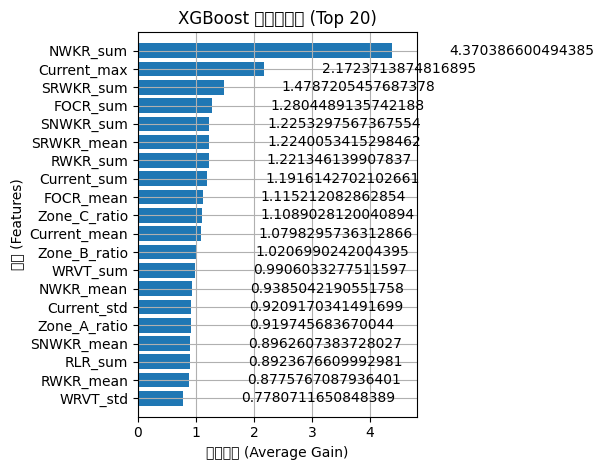

: 

In [ ]:
# Cell (例如 Cell 10.5): 使用 XGBoost 進行特徵重要性分析

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# =============================================================================
#  2. 定義特徵抽取函式 (將時間序列扁平化)
# =============================================================================
def extract_features(df: pd.DataFrame) -> dict:
    """
    從一個事件的 DataFrame 中抽取統計特徵，將其轉換為一行數據。
    """
    # df = ensure_current(df) # 確保有 'Current' 欄位
    
    # 定義要計算的統計量
    aggregations = ['mean', 'std', 'max', 'min', 'sum']
    
    # 儲存所有抽取出的特徵
    all_features = {}

    # --- A. 對連續型變數計算統計特徵 ---
    for col in CONT_COLS:
        if col in df.columns:
            # 計算該欄位的統計量
            stats = df[col].agg(aggregations)
            for stat_name, value in stats.items():
                # 建立新的特徵名稱，例如 'Current_mean', 'WRVT_std'
                new_feature_name = f"{col}_{stat_name}"
                all_features[new_feature_name] = value

    # --- B. 對二元/分類變數計算統計特徵 ---
    # 對於 0/1 的欄位，'sum' 代表 1 出現的次數，'mean' 代表 1 出現的比例
    for col in BIN_CAT_COLS:
        if col in df.columns:
            stats = df[col].agg(['sum', 'mean'])
            for stat_name, value in stats.items():
                new_feature_name = f"{col}_{stat_name}"
                all_features[new_feature_name] = value

    # --- C. 對 'Zone' 欄位進行特徵工程 ---
    # 計算每個 Zone (A, B, C) 的時間步長佔總時間的比例
    if 'Zone' in df.columns:
        zone_counts = df['Zone'].value_counts(normalize=True) # normalize=True 直接計算比例
        for zone_name in ZONES:
            feature_name = f"Zone_{zone_name}_ratio"
            all_features[feature_name] = zone_counts.get(zone_name, 0) # 如果某 Zone 不存在，比例為 0

    return all_features

# =============================================================================
#  3. 處理整個資料集，建立扁平化的特徵矩陣
# =============================================================================
print("正在從所有事件中抽取扁平化特徵 (這可能需要幾分鐘)...")

# 我們使用完整的、清洗後的資料集來進行分析，以獲得最全面的視角
# (假設 manifest_cleaned 是您經過雙重清洗後的最終版本)
full_manifest = pd.concat([train_df, val_df, test_df], ignore_index=True)

# 使用 tqdm 顯示進度條
feature_rows = [extract_features(pd.read_csv(path)) for path in tqdm(full_manifest['path'], desc="抽取特徵中")]

# 建立扁平化的 DataFrame
X_flat = pd.DataFrame(feature_rows)
y_flat = full_manifest['event_label']

# 處理可能產生的 NaN 值 (例如，當 std 為 0 時)
X_flat = X_flat.fillna(0)

print("特徵抽取完成！")
print(f"扁平化後的特徵矩陣形狀: {X_flat.shape}")

# =============================================================================
#  4. 訓練 XGBoost 模型
# =============================================================================
# print("\n🚀 正在訓練 XGBoost 模型以評估特徵重要性...")

# 初始化 XGBoost 分類器
# scale_pos_weight 用於處理類別不平衡，效果比 class_weights 更好
counts = y_flat.value_counts()
scale_pos_weight_map = {
    0: counts[1] / counts[0],
    1: 1, # '異常' 類別作為基準
    2: counts[1] / counts[2]
}
# 這是一個簡化的處理方式，對於多分類，更精確的方式需要更複雜的計算，但通常這樣效果就不錯
# 我們也可以忽略權重，因為我們的目標是看特徵重要性，而不是模型的最終性能

xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',  # 多分類問題
    num_class=len(CLASS_MAP),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)

# 訓練模型
xgb_classifier.fit(X_flat, y_flat)

print(" XGBoost 模型訓練完成！")

# =============================================================================
#  5. 視覺化特徵重要性
# =============================================================================
print("\n生成特徵重要性報告...")

# 設定圖表大小
plt.figure(figsize=(12, 10))

# 使用 XGBoost 內建的 plot_importance 繪圖
# importance_type='gain' 表示該特徵在分裂時帶來的平均增益，是個很可靠的指標
xgb.plot_importance(xgb_classifier, importance_type='gain', max_num_features=20, height=0.8, title='XGBoost 特徵重要性 (Top 20)')
plt.xlabel("平均增益 (Average Gain)")
plt.ylabel("特徵 (Features)")
plt.tight_layout() # 調整佈局以防標籤重疊
plt.show()

### Padding + Pack (DataLoader 準備)

In [49]:
# =============================================================================
#  前置準備 (Prerequisites)
# =============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- 假設這些變數來自您之前的設定 ---
CONT_COLS = ["Current", "WRVT"]
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]
# BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR"]
ZONES = ["A", "B", "C"]
BATCH_SIZE = 32

# --- 假設這個函式也已經定義 ---
def ensure_current(df: pd.DataFrame) -> pd.DataFrame:
    if "Current" in df.columns: return df
    if all(c in df.columns for c in ["NCurrent","RCurrent","NLR"]):
        return df.assign(Current=df.apply(lambda row: row["NCurrent"] if row["NLR"]==1 else row["RCurrent"], axis=1))
    if "NCurrent" in df.columns: df['Current'] = df['NCurrent']
    elif "RCurrent" in df.columns: df['Current'] = df['RCurrent']
    else:
        print(f"警告：找不到任何電流欄位，將使用 0 填充 'Current'。")
        df['Current'] = 0
    return df

# --- 在建立 Dataset 之前 ---

# 1. 找出所有訓練集中的連續型特徵資料，合併起來
# 注意：這一步會比較耗時，因為需要讀取所有訓練集檔案
cont_data_list = []
for path in train_df['path']:
    df = pd.read_csv(path)
    df = ensure_current(df) # 確保有 'Current' 欄位
    cont_data_list.append(df[CONT_COLS])

all_train_cont_data = pd.concat(cont_data_list, ignore_index=True)

# 2. 在所有訓練資料上擬合 StandardScaler
scaler = StandardScaler()
scaler.fit(all_train_cont_data)

print("StandardScaler 已在訓練集上擬合完畢！")

# =============================================================================
#  【Debug 專用版】 PyTorch Dataset 類別
# =============================================================================
class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, zones, scaler):
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.zones = zones
        self.zone_to_onehot = {z: torch.tensor([1.0 if z == Z else 0.0 for Z in zones]) for z in zones}
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        # 先取得 path，這樣在任何錯誤發生時都能印出
        row = self.manifest.iloc[idx]
        path = row['path']
        
        try:
            label = row['event_label']
            df = pd.read_csv(path)
            df = ensure_current(df)

            # --- 在組合 feats 之前，對連續特徵進行 transform ---
            if not df[self.cont_cols].empty:
                df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])
                
            feats = []

            for c in self.cont_cols:
                if c in df.columns:
                    feats.append(torch.tensor(df[c].values, dtype=torch.float32).unsqueeze(1))
            
            for c in self.bin_cat_cols:
                if c in df.columns:
                    vals = df[c].fillna(0).astype(int).clip(0, 1).values
                    feats.append(torch.tensor(vals, dtype=torch.float32).unsqueeze(1))
            
            if 'Zone' in df.columns:
                try:
                    # 可能出錯的 Zone 處理
                    zone_onehot = df['Zone'].map(self.zone_to_onehot).tolist()
                    feats.append(torch.stack(zone_onehot))
                except TypeError as e:
                    # 捕獲 TypeError，印出詳細的 Debug 報告
                    print("\n" + "="*80)
                    print("💥💥💥 已捕獲 TypeError！問題檔案已定位！ 💥💥💥")
                    print(f"錯誤發生在處理以下檔案時:")
                    print(f"  ->  {path}")
                    print("\n錯誤原因分析:")
                    print("  - 這通常是因為該檔案的 'Zone' 欄位中包含了缺失值 (NaN) 或無法識別的值。")
                    
                    problematic_rows = df[df['Zone'].apply(lambda z: not isinstance(z, str) or z not in self.zone_to_onehot)]
                    if not problematic_rows.empty:
                        print("\n  以下是該檔案中有問題的 'Zone' 欄位內容 (前 5 行):")
                        print(problematic_rows[['Zone']].head())

                    print("\n請手動檢查上述 CSV 檔案，修正 'Zone' 欄位的內容。")
                    print("="*80 + "\n")
                    raise e # 重新拋出錯誤以停止程式

            if not feats:
                return {"features": torch.empty(0, 0), "length": 0, "label": torch.tensor(-1, dtype=torch.long)}

            features_tensor = torch.cat(feats, dim=1)
            
            return {
                "features": features_tensor,
                "length": features_tensor.shape[0],
                "label": torch.tensor(label, dtype=torch.long)
            }
        
        # 【修正縮排】這個 except 區塊現在在 __getitem__ 內部，可以捕捉所有錯誤
        except Exception as e:
            print(f"\n在處理檔案 {path} 時發生了預期外的錯誤 (不是 TypeError): {e}")
            # 為了 Debug，我們也重新拋出錯誤
            raise e

# =============================================================================
#  步驟 2: 定義 collate_fn 函式
# =============================================================================
def collate_fn(batch):
    batch = [item for item in batch if item['length'] > 0]
    if not batch:
        return {"features": torch.empty(0, 0, 0), "lengths": torch.empty(0), "labels": torch.empty(0)}

    features_list = [item['features'] for item in batch]
    lengths_list = [item['length'] for item in batch]
    labels_list = [item['label'] for item in batch]

    padded_features = pad_sequence(features_list, batch_first=True, padding_value=0.0)

    return {
        "features": padded_features,
        "lengths": torch.tensor(lengths_list, dtype=torch.long),
        "labels": torch.stack(labels_list)
    }

# =============================================================================
#  步驟 3: 實例化 Dataset 和 DataLoader
# =============================================================================
print("\n" + "="*50)
print("       正在建立 Dataset 和 DataLoader...")
print("="*50)

train_dataset = EventDataset(train_df, CONT_COLS, BIN_CAT_COLS, ZONES, scaler)
val_dataset = EventDataset(val_df, CONT_COLS, BIN_CAT_COLS, ZONES, scaler)
test_dataset = EventDataset(test_df, CONT_COLS, BIN_CAT_COLS, ZONES, scaler)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("DataLoader 建立完成！")

# =============================================================================
#  步驟 4: 驗證 DataLoader 的輸出
# =============================================================================
print("\n" + "="*50)
print("              驗證 DataLoader 輸出")
print("="*50)

try:
    first_batch = next(iter(train_loader))
    padded_features = first_batch['features']
    lengths = first_batch['lengths']
    labels = first_batch['labels']
    print(f"成功從 train_loader 取出一個批次！")
    print(f"\n批次中 Features 的形狀: {padded_features.shape}")
    print(f"批次中 Lengths 的形狀: {lengths.shape}")
    print(f"批次中 Labels 的形狀: {labels.shape}")
    print("\n此批次中前 10 筆資料的真實長度:", lengths[:10].tolist())
    print("\n\n資料已準備就緒，可以與 `pack_padded_sequence` 配合並餵入 LSTM 模型！")
except StopIteration:
    print("錯誤：訓練資料集為空，無法從 train_loader 中取出資料。")
except Exception as e:
    print(f"\n在嘗試從 DataLoader 取出第一個批次時發生錯誤。請查看上面的 Debug 報告。")
    print(f"具體錯誤訊息: {e}")

print("="*50)

StandardScaler 已在訓練集上擬合完畢！

       正在建立 Dataset 和 DataLoader...
DataLoader 建立完成！

              驗證 DataLoader 輸出
成功從 train_loader 取出一個批次！

批次中 Features 的形狀: torch.Size([32, 308, 14])
批次中 Lengths 的形狀: torch.Size([32])
批次中 Labels 的形狀: torch.Size([32])

此批次中前 10 筆資料的真實長度: [280, 302, 303, 292, 296, 291, 299, 305, 298, 293]


資料已準備就緒，可以與 `pack_padded_sequence` 配合並餵入 LSTM 模型！


### PyTorch & CUDA 檢查

In [48]:
import torch

# 檢查 PyTorch 版本
print(torch.__version__)

# 這是關鍵：檢查 PyTorch 是為哪個 CUDA 版本編譯的
print(torch.version.cuda)

# 確認是否能使用 CUDA
print(torch.cuda.is_available())

# --- 環境設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"將使用設備: {device}")

2.5.1+cu121
12.1
True
將使用設備: cuda


### 模型訓練

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # 用於顯示漂亮的進度條
import numpy as np

# --- 訓練設定 ---
# 透過檢查第一個批次來自動獲取特徵數量，讓程式碼更具彈性
try:
    temp_batch = next(iter(train_loader))
    INPUT_SIZE = temp_batch['features'].shape[2]
except (StopIteration, IndexError):
    print("無法從 DataLoader 自動獲取 INPUT_SIZE，請手動設定。")
    # 如果 DataLoader 為空，手動設定一個預期值
    INPUT_SIZE = len(CONT_COLS) + len(BIN_CAT_COLS) + len(ZONES)

HIDDEN_SIZE = 128   # LSTM 隱藏層的大小
NUM_LAYERS = 2      # LSTM 的層數
NUM_CLASSES = len(CLASS_MAP) # 類別數量 (正常, 異常, 故障 -> 3)
LEARNING_RATE = 0.001
NUM_EPOCHS = 20     # 訓練的回合數，您可以依據收斂情況調整
DROPOUT = 0.3       # Dropout 比率，防止過擬合

# --- 環境設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"將使用設備: {device}")
print(f"自動偵測到的特徵數量 (Input Size): {INPUT_SIZE}")

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,  # <<< 極度重要！因為我們的 DataLoader 輸出是 (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0 # 只有多層 LSTM 才能加 dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        # 1. 使用 pack_padded_sequence 來處理 padding
        #    這會告訴 LSTM 忽略填充的部分，大大提升效率和準確性
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # 2. 將打包好的序列餵給 LSTM
        #    我們只需要 LSTM 的隱藏狀態 h_n 來做分類
        _, (h_n, _) = self.lstm(packed_input)
        
        # 3. 獲取最後一層的隱藏狀態
        #    h_n 的形狀是 (num_layers, batch_size, hidden_size)
        #    我們取最後一層 (-1) 作為整個序列的特徵表示
        last_hidden_state = h_n[-1]
        
        # 4. 進行分類
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out
    
# 實例化模型
model = LSTMClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)

# --- 【新增程式碼】計算類別權重 ---
# 1. 統計訓練集中各類別的數量
class_counts = train_df['event_label'].value_counts().sort_index()

# 2. 計算權重 (公式：總樣本數 / (類別數 * 該類別樣本數))
#    這會讓樣本數越少的類別，權重越高
weights = len(train_df) / (len(class_counts) * class_counts)

# 3. 將權重轉換為 PyTorch Tensor 並移到對應的設備上
class_weights = torch.tensor(weights.values, dtype=torch.float32).to(device)

print("\n計算出的類別權重 (用於損失函數):")
print(f"  正常(0): {class_weights[0]:.2f}, 異常(1): {class_weights[1]:.2f}, 故障(2): {class_weights[2]:.2f}\n")

# --- 【修改程式碼】定義損失函數時，傳入權重 ---
# 原始程式碼: criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights) # <<< 在這裡把權重加上去

# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 打印模型結構
print(model)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(loader, desc="訓練中 (Training)"):
        features = batch['features'].to(device)
        lengths = batch['lengths']
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        
        outputs = model(features, lengths)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # 在評估時，不需要計算梯度
        for batch in tqdm(loader, desc="評估中 (Evaluating)"):
            features = batch['features'].to(device)
            lengths = batch['lengths']
            labels = batch['labels'].to(device)

            outputs = model(features, lengths)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc, all_labels, all_predictions

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1} 結果:")
    print(f"  訓練損失 (Train Loss): {train_loss:.4f} | 訓練準確率 (Train Acc): {train_acc:.4f}")
    print(f"  驗證損失 (Val Loss):   {val_loss:.4f} | 驗證準確率 (Val Acc):   {val_acc:.4f}")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

print("\n訓練完成！")

將使用設備: cuda
自動偵測到的特徵數量 (Input Size): 14

計算出的類別權重 (用於損失函數):
  正常(0): 6.87, 異常(1): 0.47, 故障(2): 1.39

LSTMClassifier(
  (lstm): LSTM(14, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

--- Epoch 1/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 結果:
  訓練損失 (Train Loss): 1.0939 | 訓練準確率 (Train Acc): 0.4077
  驗證損失 (Val Loss):   1.1124 | 驗證準確率 (Val Acc):   0.1642

--- Epoch 2/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 結果:
  訓練損失 (Train Loss): 1.0676 | 訓練準確率 (Train Acc): 0.2540
  驗證損失 (Val Loss):   1.1455 | 驗證準確率 (Val Acc):   0.1642

--- Epoch 3/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 結果:
  訓練損失 (Train Loss): 1.0687 | 訓練準確率 (Train Acc): 0.2422
  驗證損失 (Val Loss):   1.0989 | 驗證準確率 (Val Acc):   0.4363

--- Epoch 4/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 結果:
  訓練損失 (Train Loss): 1.0577 | 訓練準確率 (Train Acc): 0.2332
  驗證損失 (Val Loss):   1.1052 | 驗證準確率 (Val Acc):   0.1667

--- Epoch 5/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 結果:
  訓練損失 (Train Loss): 1.0610 | 訓練準確率 (Train Acc): 0.2430
  驗證損失 (Val Loss):   1.1107 | 驗證準確率 (Val Acc):   0.1667

--- Epoch 6/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 結果:
  訓練損失 (Train Loss): 1.0567 | 訓練準確率 (Train Acc): 0.2715
  驗證損失 (Val Loss):   1.1111 | 驗證準確率 (Val Acc):   0.3211

--- Epoch 7/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 結果:
  訓練損失 (Train Loss): 1.0519 | 訓練準確率 (Train Acc): 0.2393
  驗證損失 (Val Loss):   1.1118 | 驗證準確率 (Val Acc):   0.1912

--- Epoch 8/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 結果:
  訓練損失 (Train Loss): 1.0531 | 訓練準確率 (Train Acc): 0.3322
  驗證損失 (Val Loss):   1.1094 | 驗證準確率 (Val Acc):   0.2696

--- Epoch 9/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 結果:
  訓練損失 (Train Loss): 1.0562 | 訓練準確率 (Train Acc): 0.3000
  驗證損失 (Val Loss):   1.1111 | 驗證準確率 (Val Acc):   0.2819

--- Epoch 10/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 結果:
  訓練損失 (Train Loss): 1.0487 | 訓練準確率 (Train Acc): 0.2943
  驗證損失 (Val Loss):   1.1126 | 驗證準確率 (Val Acc):   0.3039

--- Epoch 11/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 結果:
  訓練損失 (Train Loss): 1.0500 | 訓練準確率 (Train Acc): 0.3286
  驗證損失 (Val Loss):   1.1059 | 驗證準確率 (Val Acc):   0.2794

--- Epoch 12/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 結果:
  訓練損失 (Train Loss): 1.0608 | 訓練準確率 (Train Acc): 0.3286
  驗證損失 (Val Loss):   1.1250 | 驗證準確率 (Val Acc):   0.3211

--- Epoch 13/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 結果:
  訓練損失 (Train Loss): 1.0561 | 訓練準確率 (Train Acc): 0.3844
  驗證損失 (Val Loss):   1.1259 | 驗證準確率 (Val Acc):   0.2843

--- Epoch 14/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 結果:
  訓練損失 (Train Loss): 1.0522 | 訓練準確率 (Train Acc): 0.3180
  驗證損失 (Val Loss):   1.1045 | 驗證準確率 (Val Acc):   0.2132

--- Epoch 15/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 結果:
  訓練損失 (Train Loss): 1.0591 | 訓練準確率 (Train Acc): 0.2756
  驗證損失 (Val Loss):   1.1112 | 驗證準確率 (Val Acc):   0.2696

--- Epoch 16/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 結果:
  訓練損失 (Train Loss): 1.0488 | 訓練準確率 (Train Acc): 0.3021
  驗證損失 (Val Loss):   1.1212 | 驗證準確率 (Val Acc):   0.2525

--- Epoch 17/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 結果:
  訓練損失 (Train Loss): 1.0538 | 訓練準確率 (Train Acc): 0.2581
  驗證損失 (Val Loss):   1.1056 | 驗證準確率 (Val Acc):   0.2892

--- Epoch 18/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 結果:
  訓練損失 (Train Loss): 1.0450 | 訓練準確率 (Train Acc): 0.3428
  驗證損失 (Val Loss):   1.1451 | 驗證準確率 (Val Acc):   0.2623

--- Epoch 19/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 結果:
  訓練損失 (Train Loss): 1.0411 | 訓練準確率 (Train Acc): 0.2548
  驗證損失 (Val Loss):   1.1038 | 驗證準確率 (Val Acc):   0.2279

--- Epoch 20/20 ---


訓練中 (Training):   0%|          | 0/77 [00:00<?, ?it/s]

評估中 (Evaluating):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 結果:
  訓練損失 (Train Loss): 1.0423 | 訓練準確率 (Train Acc): 0.2638
  驗證損失 (Val Loss):   1.1162 | 驗證準確率 (Val Acc):   0.2525

訓練完成！


### 測試評估


          在測試集 (Test Set) 上進行最終評估


評估中 (Evaluating):   0%|          | 0/39 [00:00<?, ?it/s]

測試集最終結果:
  測試損失 (Test Loss): 1.0523
  測試準確率 (Test Acc): 0.2470

                   最終評估報告

分類報告 (Classification Report):

              precision    recall  f1-score   support

          正常       0.07      0.53      0.13        60
          異常       0.67      0.12      0.20       876
          故障       0.27      0.58      0.36       295

    accuracy                           0.25      1231
   macro avg       0.34      0.41      0.23      1231
weighted avg       0.54      0.25      0.23      1231


混淆矩陣 (Confusion Matrix):



/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25925 (\N{CJK UNIFIED IDEOGRAPH-6545}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 38556 (\N{CJK UNIFIED IDEOGRAPH-969C}) missing from font(s) DejaVu Sans.
  fig.canv

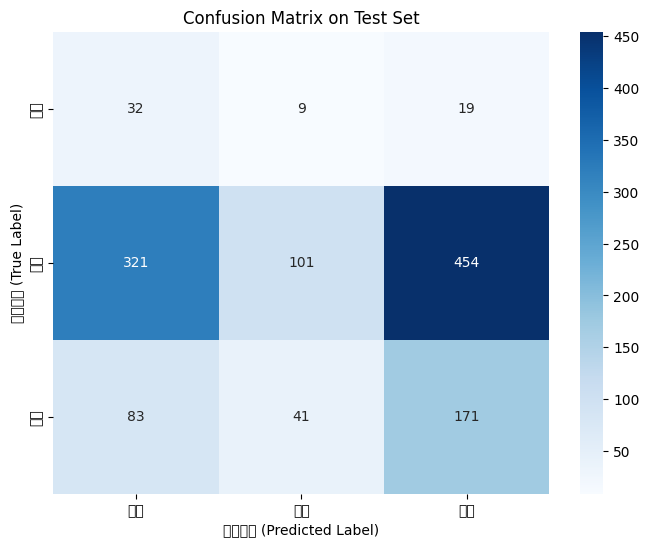

In [53]:
print("\n" + "="*50)
print("          在測試集 (Test Set) 上進行最終評估")
print("="*50)

test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)

print(f"測試集最終結果:")
print(f"  測試損失 (Test Loss): {test_loss:.4f}")
print(f"  測試準確率 (Test Acc): {test_acc:.4f}")

print("\n" + "="*50)
print("                   最終評估報告")
print("="*50)

# 產生分類報告
# 將數字標籤轉換回中文名稱，讓報告更易讀
target_names = [INV_CLASS_MAP[i] for i in range(len(CLASS_MAP))]
report = classification_report(y_true, y_pred, target_names=target_names)
print("\n分類報告 (Classification Report):\n")
print(report)

# 產生並視覺化混淆矩陣
print("\n混淆矩陣 (Confusion Matrix):\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('預測標籤 (Predicted Label)')
plt.ylabel('真實標籤 (True Label)')
plt.title('Confusion Matrix on Test Set')
plt.show()